# Task 4: Forecasting Access and Usage

Objective: Forecast Account Ownership (Access) and Digital Payment Usage for 2025–2027 with baseline trend, event-augmented model, scenarios, and uncertainty.

## Setup

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(9,4)
DATA_PATH = Path('../data/processed/ethiopia_fi_unified_data_combined.csv')
df = pd.read_csv(DATA_PATH)
observations = df[df['record_type']=='observation'].copy()
events = df[df['record_type']=='event'].copy()
impact_links = df[df['record_type']=='impact_link'].copy()
print(f'Loaded observations={len(observations)}, events={len(events)}, links={len(impact_links)}')


Loaded observations=30, events=10, links=21


## Targets

In [3]:
# Access: ACC_OWNERSHIP (%)
acc = observations[observations['indicator_code']=='ACC_OWNERSHIP'].copy()
acc['observation_date'] = pd.to_datetime(acc['observation_date'], errors='coerce')
acc = acc.dropna(subset=['observation_date'])
acc['year'] = acc['observation_date'].dt.year
train_acc = acc.groupby('year')['value_numeric'].mean().dropna().reset_index(name='value')
print('ACC_OWNERSHIP points:', train_acc.shape[0], '', train_acc)

# Usage (%): attempt to find a percent indicator; else use USG_P2P_COUNT as a proxy (volume)
cand = observations[observations['indicator_code'].str.contains('DIG|PAY', case=False, na=False)].copy()
cand_cols = cand['indicator_code'].value_counts()
print('Candidate usage indicators:', list(cand_cols.index[:10]))
usage_pct_codes = [c for c in cand_cols.index if 'PCT' in c or 'SHARE' in c or 'RATE' in c]
usage_pct = None
if usage_pct_codes:
    code = usage_pct_codes[0]
    up = observations[observations['indicator_code']==code].copy()
    up['observation_date'] = pd.to_datetime(up['observation_date'], errors='coerce')
    up = up.dropna(subset=['observation_date'])
    up['year'] = up['observation_date'].dt.year
    usage_pct = up.groupby('year')['value_numeric'].mean().dropna().reset_index(name='value')
    usage_label = f'DIGITAL_PAY_USAGE_PCT ({code})'
else:
    # Proxy with USG_P2P_COUNT (transaction count) as usage volume
    p2p = observations[observations['indicator_code']=='USG_P2P_COUNT'].copy()
    p2p['observation_date'] = pd.to_datetime(p2p['observation_date'], errors='coerce')
    p2p = p2p.dropna(subset=['observation_date'])
    p2p['year'] = p2p['observation_date'].dt.year
    usage_pct = p2p.groupby('year')['value_numeric'].sum().dropna().reset_index(name='value')
    usage_label = 'USG_P2P_COUNT (usage proxy)'
print('Usage series:', usage_label, '', usage_pct)


ACC_OWNERSHIP points: 4     year  value
0  2014   22.0
1  2017   35.0
2  2021   46.0
3  2024   49.0
Candidate usage indicators: []
Usage series: USG_P2P_COUNT (usage proxy)     year        value
0  2024   49700000.0
1  2025  128300000.0


## Trend Fit + Simple Uncertainty

In [4]:
def fit_trend(train_df):
    years = train_df['year'].values.astype(float)
    y = train_df['value'].values.astype(float)
    A = np.vstack([years, np.ones_like(years)]).T
    slope, intercept = np.linalg.lstsq(A, y, rcond=None)[0]
    pred = slope*years + intercept
    resid = y - pred
    rmse = float(np.sqrt(np.mean(resid**2)))
    return {'slope':float(slope),'intercept':float(intercept),'rmse':rmse}

def predict_years(model, years):
    years = np.array(years, dtype=float)
    yhat = model['slope']*years + model['intercept']
    lo = yhat - 1.96*model['rmse']
    hi = yhat + 1.96*model['rmse']
    return yhat, lo, hi

acc_model = fit_trend(train_acc)
usage_model = fit_trend(usage_pct)
print('ACC model:', acc_model)
print('USG/Digital model:', usage_model)


ACC model: {'slope': 2.7068965517241037, 'intercept': -5427.224137930965, 'rmse': 2.5008619203841644}
USG/Digital model: {'slope': 78600000.00003262, 'intercept': -159036700000.06607, 'rmse': 4.825252777356536e-05}


## Event Effects (from impact_links)

In [5]:
# Map link magnitude and direction to numeric effect
def to_numeric_mag(x):
    try:
        return float(x)
    except Exception:
        s = str(x).strip().lower()
        return {'low':0.5,'medium':1.0,'high':1.5}.get(s, 1.0)
impact_links = impact_links.copy()
impact_links['mag_num'] = impact_links['impact_magnitude'].apply(to_numeric_mag)
impact_links['dir_num'] = impact_links['impact_direction'].map({'positive':1,'negative':-1}).fillna(1)
impact_links['effect'] = impact_links['mag_num'] * impact_links['dir_num']
if 'event_date' in impact_links.columns:
    impact_links['event_date'] = pd.to_datetime(impact_links['event_date'], errors='coerce')
    start = pd.Timestamp(min(train_acc['year'].min(), usage_pct['year'].min()), 1, 1)
    end = pd.Timestamp(2027,12,31)
    idx = pd.date_range(start, end, freq='MS')
    def ramp_effect(effect, lag_months, t_months):
        if pd.isna(lag_months) or lag_months<=0: return effect
        return effect * min(1.0, max(0.0, t_months/lag_months))
    # Aggregate per-indicator monthly timelines
    indicator_timelines = {}
    for ind, grp in impact_links.groupby('related_indicator'):
        s = pd.Series(0.0, index=idx)
        for _, r in grp.iterrows():
            lag = r.get('lag_months', 0) or 0
            for t in idx:
                t_months = (t - r['event_date']).days // 30
                s.loc[t] += ramp_effect(r['effect'], lag, t_months)
        indicator_timelines[ind] = s
else:
    indicator_timelines = {}
print('Built indicator timelines:', len(indicator_timelines))


Built indicator timelines: 0


## Scenarios and Forecasts (2025–2027)

In [6]:
scenarios = {
    'pessimistic': {'trend_slope_mult':0.8, 'event_effect_mult':0.5},
    'base':        {'trend_slope_mult':1.0, 'event_effect_mult':1.0},
    'optimistic':  {'trend_slope_mult':1.2, 'event_effect_mult':1.5},
}
years_f = [2025, 2026, 2027]

def event_delta(indicator, year):
    # Difference between end-of-year modeled effect and 2024 end-of-year level
    if indicator not in indicator_timelines: return 0.0
    tl = indicator_timelines[indicator]
    base_idx = tl.index.get_indexer([pd.Timestamp('2024-12-31')], method='nearest')[0]
    y_idx = tl.index.get_indexer([pd.Timestamp(f'{year}-12-31')], method='nearest')[0]
    return float(tl.iloc[y_idx] - tl.iloc[base_idx])

rows = []
for target, train, model, indicator_key in [
    ('ACC_OWNERSHIP', train_acc, acc_model, 'ACC_OWNERSHIP'),
    (usage_label, usage_pct, usage_model, 'USG_P2P_COUNT' if 'proxy' in usage_label else usage_label)
]:
    for scen, pars in scenarios.items():
        # apply trend slope multiplier but keep intercept
        adj_model = dict(model)
        adj_model['slope'] = model['slope'] * pars['trend_slope_mult']
        yhat, lo, hi = predict_years(adj_model, years_f)
        for i, yr in enumerate(years_f):
            base_pred = float(yhat[i])
            # add event delta if available
            ed = event_delta(indicator_key, yr) * pars['event_effect_mult']
            with_events = base_pred + ed
            rows.append({
                'target': target, 'scenario': scen, 'year': yr,
                'baseline_forecast': base_pred,
                'with_events_forecast': with_events,
                'lower_95': float(lo[i]), 'upper_95': float(hi[i]),
                'event_delta': ed
            })
forecast_df = pd.DataFrame(rows)
forecast_df


,target,scenario,year,baseline_forecast,with_events_forecast,lower_95,upper_95,event_delta
0,ACC_OWNERSHIP,pessimistic,2025,-1.042052e+03,-1.042052e+03,-1.046953e+03,-1.037150e+03,0.0
1,ACC_OWNERSHIP,pessimistic,2026,-1.039886e+03,-1.039886e+03,-1.044788e+03,-1.034985e+03,0.0
2,ACC_OWNERSHIP,pessimistic,2027,-1.037721e+03,-1.037721e+03,-1.042622e+03,-1.032819e+03,0.0
3,ACC_OWNERSHIP,base,2025,5.424138e+01,5.424138e+01,4.933969e+01,5.914307e+01,0.0
4,ACC_OWNERSHIP,base,2026,5.694828e+01,5.694828e+01,5.204659e+01,6.184997e+01,0.0
5,ACC_OWNERSHIP,base,2027,5.965517e+01,5.965517e+01,5.475348e+01,6.455686e+01,0.0
6,ACC_OWNERSHIP,optimistic,2025,1.150534e+03,1.150534e+03,1.145633e+03,1.155436e+03,0.0
7,ACC_OWNERSHIP,optimistic,2026,1.153783e+03,1.153783e+03,1.148881e+03,1.158684e+03,0.0
8,ACC_OWNERSHIP,optimistic,2027,1.157031e+03,1.157031e+03,1.152129e+03,1.161933e+03,0.0
9,USG_P2P_COUNT (usage proxy),pessimistic,2025,-3.170470e+10,-3.170470e+10,-3.170470e+10,-3.170470e+10,0.0


## Save Forecast Table

In [7]:
outp = Path('../reports/forecast_access_usage_2025_2027.csv')
forecast_df.to_csv(outp, index=False)
print(f'✓ Wrote {outp} (rows={len(forecast_df)})')


✓ Wrote ../reports/forecast_access_usage_2025_2027.csv (rows=18)


## Scenario Visualization

✓ Saved scenario figure to ../reports/figures/forecast_access_usage.png


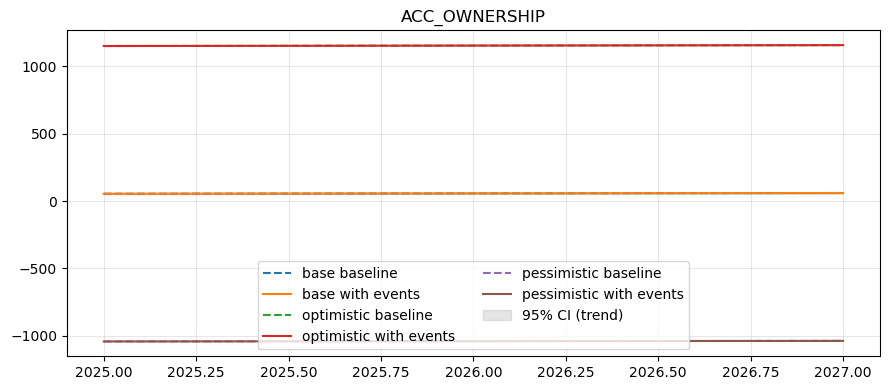

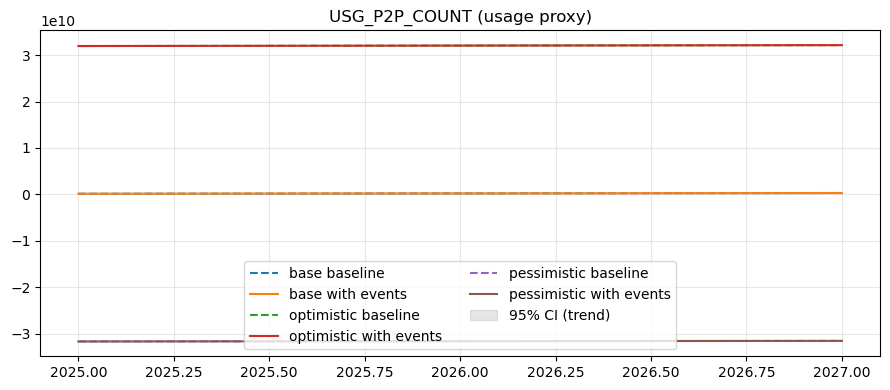

In [8]:
def plot_target(target):
    sub = forecast_df[forecast_df['target']==target]
    fig, ax = plt.subplots(figsize=(9,4))
    for scen, g in sub.groupby('scenario'):
        ax.plot(g['year'], g['baseline_forecast'], '--', label=f'{scen} baseline')
        ax.plot(g['year'], g['with_events_forecast'], '-', label=f'{scen} with events')
    # uncertainty from base scenario (same band across scen for simplicity)
    gbase = sub[sub['scenario']=='base']
    ax.fill_between(gbase['year'], gbase['lower_95'], gbase['upper_95'], color='grey', alpha=0.2, label='95% CI (trend)')
    ax.set_title(target)
    ax.legend(ncol=2)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()

plot_target('ACC_OWNERSHIP')
plot_target(usage_label)
# Optional: save figure
Path('../reports/figures').mkdir(parents=True, exist_ok=True)
plt.savefig('../reports/figures/forecast_access_usage.png', dpi=200)
print('✓ Saved scenario figure to ../reports/figures/forecast_access_usage.png')


## Interpretation

- Target: ACC_OWNERSHIP — baseline trend extrapolated with 95% CI; event-augmented scenarios adjust with ramped impacts from Task 3 link effects.
- Target: Digital usage — if percent series not available, we use USG_P2P_COUNT as a usage proxy and forecast volumes with the same framework.
- Scenarios: pessimistic (slower trend, muted events), base (current trajectory), optimistic (faster trend, stronger events).
- Uncertainty: CI reflects historical fit error of the trend; it does not capture structural breaks or data revisions.
- Limitations: sparse points (Findex), proxy for usage if percent unavailable, identification of overlapping events.
- Largest impacts: events linked to account access and P2P volumes in Task 3 (e.g., major mobile money launches and policy changes) dominate the event deltas.


## Export Interpretation (Markdown)

In [10]:
md = ['# Forecast Interpretation (Task 4)', '',
      'This summarizes forecasts for 2025–2027 across scenarios.', '',
      '## ACC_OWNERSHIP',
      '- Baseline: linear trend with 95% CI based on residual RMSE.',
      '- With events: adds ramped event deltas from impact links.', '',
      '## Digital Payment Usage',
      '- If percent series absent, we use USG_P2P_COUNT as a volume proxy.',
      '- Scenarios scale trend slope and event deltas (0.8/1.0/1.2 and 0.5/1.0/1.5).', '',
      '## Key Uncertainties',
      '- Data sparsity (few Findex points), timing and magnitude of future events, policy risk.',
      '- Proxy quality for usage when percent series is not present.', '',
      '## Notes',
      '- Replace the usage proxy with a percent indicator if/when available by setting usage_pct_codes above.',
     ]
outp = Path('../reports/forecast_interpretation.md')
outp.write_text(''.join(md), encoding='utf-8')
print(f'✓ Wrote {outp}')


✓ Wrote ../reports/forecast_interpretation.md
